In [ ]:
import argparse
import os
import time
import numpy as np
import sys
import torch
from torch.utils.data import DataLoader
from TM_model import Model
from TM_model.archs import flow_warp
import cv2
from utils.utils_image import test_tensor_img
from data.dataset_LMDB_train import DataLoaderTurbVideoTest
# from data.dataset_LMDB_train import DataLoaderTurbVideo
import json, math
# from utils.simulator_zernike_1D import Simulator
import matplotlib.pyplot as plt
from torchmetrics.functional import peak_signal_noise_ratio as tmf_psnr
from utils.NAFNet_arch import NAFNet_zer

In [19]:
class Args:
    def __init__(self):
        self.batch_size =1
        self.patch_size = 240
        self.num_frames = 30
        self.chunk_frames = 30
        self.data_path = '/home/zhan3275/data/lmdb_ATSyn/test_lmdb/'
        self.info_path = '/home/zhan3275/data/lmdb_ATSyn/test_lmdb/test_info.json'
        # self.data_path = '/home/zhan3275/data/lmdb_ATSyn/train_lmdb/'
        # self.info_path = '/home/zhan3275/data/lmdb_ATSyn/train_lmdb/train_info.json'
        # self.result_path = '/home/zhan3275/data/simulated_data/test_MBP_video'
        self.model_path = 'model_zoo/model_dynamic.pth'
        self.num_workers = 8
        self.model = 'MambaTM'
        self.n_features = 16
        self.n_blocks = 6
        self.future_frames = 2
        self.past_frames = 2
        self.activation = 'gelu'
        self.output_all = True
        self.reblur_path = "/home/zhan3275/turb/recon/MambaTM/LPD_learning/model_zoo/NAF_decoder.pth"
        
def get_args():
    return Args()

In [51]:
class TurbSim(object):
    def __init__(self, nb, width, ckpt_path):
        self.blur_model = NAFNet_zer(in_channels=1, out_channel=1, width=width, middle_blk_num=1,
                      enc_blk_nums=[1,1,1,nb], dec_blk_nums=[1,1,1,1]).cuda()
        loaded = torch.load(ckpt_path)
        self.blur_model.load_state_dict(loaded["decoder"])
        for prm in self.blur_model.parameters():
            prm.requires_grad = False
        if torch.cuda.device_count()>1:
            self.blur_model = torch.nn.DataParallel(self.blur_model, device_ids=[i for i in range(torch.cuda.device_count())]).cuda()
        print("TurbSim loaded!")
    
    def reblur(self, img, LPD):
        B, T, C, H, W = img.shape
        img = img.flatten(0, 1)
        LPD = LPD.flatten(0, 1)
        tilt, mu, logvar = LPD[:,:2,:,:], LPD[:,2:3,:,:], LPD[:,3:4,:,:]
        log_var = torch.clamp(logvar, min=-10.0, max = 10.0)
        tilt_img = flow_warp(img, tilt)
        z = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
        kld = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())
        # turb_img = self.blur_model(tilt_img.mean(1, keepdim=True), z)
        turb_img = self.blur_model(tilt_img, z)
        return tilt_img.view(B, T, C, H, W), turb_img.view(B, T, -1, H, W), kld

In [53]:
args = get_args()
input_dir = args.data_path
model_path = args.model_path
patch_size = args.patch_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TS = TurbSim(8, 16, args.reblur_path)

TurbSim loaded!


In [9]:
test_dataset = DataLoaderTurbVideoTest(args.data_path, args.info_path, turb=True, tilt=False, blur=False, level='medium', \
                                    num_frames=args.num_frames, patch_unit=8)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, drop_last=False, pin_memory=True)

In [20]:
# train_dataset = DataLoaderTurbVideo(args.data_path, args.info_path, turb=True, tilt=True, blur=False, \
#                                     num_frames=args.num_frames, patch_size=args.patch_size, noise=0.0001, is_train=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, drop_last=True, pin_memory=True)

In [52]:
def get_psnr(inp, redgd):
    psnr_list = []
    for b in range(inp.shape[0]):
        for i in range(inp.shape[1]):
            img = inp[b, i, ...].data.clamp_(0, 1).unsqueeze(0)
            img_gt = redgd[b, i, ...].data.clamp_(0, 1).unsqueeze(0)
            psnr_list.append(tmf_psnr(img, img_gt, data_range=1.0).item())
    return sum(psnr_list)/len(psnr_list)

def cosine(start_value, end_value, steps, current_step):
    cosine_value = (1 + math.cos(math.pi * current_step / steps)) / 2
    current_value = start_value + (end_value - start_value) * (1 - cosine_value)
    return current_value

def exponential_decay(start_value, end_value, steps, current_step):
    decay_rate = math.log(end_value / start_value) / steps
    current_value = start_value * math.exp(decay_rate * current_step)
    return current_value

In [20]:
model = Model(args).cuda()
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint.keys() else checkpoint)
model = model.eval()
for param in model.parameters():
    param.requires_grad = False

In [126]:
def rf_reg(z, w=[1e-5, 1e-5, 1e-5]):
    return w[0] * torch.norm(z[:, 1:, :, ...]-z[:, :-1, :, ...], p=1) \
        + w[1] * torch.norm(z[...,1:, :]-z[...,:-1, :], p=1) \
        + w[2] * torch.norm(z[...,:, 1:]-z[...,:, :-1], p=1)
    
def cost(res, sim, inp, lpd_step, sigma=1, factor=1):
    print(res.shape, inp.shape)
    redgd = sim.blur_model(res[0], lpd_step[0]).unsqueeze(dim=0)
    
    # 1,26,35,240,240
    return 1/(2*sigma**2) * torch.norm(inp[0]-redgd), redgd, torch.norm(inp[0]-redgd)
    # return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
    #         + factor*rf_reg(zer_step[:, :, :2, ...], [1e-5, 2e-5, 2e-5]) \
    #         + factor*rf_reg(zer_step[:, :, 2:, ...], [5e-6, 1e-5, 1e-5]) \
    #         + factor*2e-5 * torch.norm(zer_step[:,:,:2,...]) \
    #         + factor*1e-5 * torch.norm(zer_step[:,:,2:,...]), redgd, torch.norm(inp[:,2:-2,...]-redgd)

In [81]:
test_info = json.load(open(args.info_path, "r"))
for k,v in test_info.items():
    if isinstance(v, dict) and v["video_name"] == data[-1][0]:
        print(v)

{'video_name': 'gymnastics_3661.mp4', 'turb_level': 'medium', 'temp_corr': 0.8396986315068358, 'blur_kernel': 15, 'length': 523, 'h': 480, 'w': 270}


In [22]:
with torch.no_grad():
    for data in test_loader:
    # for data in train_loader:
        input_all = data[0][..., :args.patch_size, :args.patch_size].cuda()
        gt = data[1][..., :args.patch_size, :args.patch_size].cuda()
        # print(data[0][..., :args.patch_size, :args.patch_size].shape)
        break
input_all = input_all[0:1,...]
input_all.shape

In [92]:
brs_sample_path = "/home/zhan3275/data/BRIAR_video_classifier/BRIAR_test_set/videos_before_restoration/BRS3_EP4.2.0_G03283_field_0000000029/"
brs_images = [cv2.cvtColor(cv2.imread(os.path.join(brs_sample_path, f"frame_{i+22:05d}.png")), cv2.COLOR_BGR2RGB) for i in range(30)]
input_all = torch.stack([torch.tensor(img)/255.0 for img in brs_images], 0).permute(0,3,1,2).unsqueeze(0).cuda()

In [93]:
input_all.shape

torch.Size([1, 30, 3, 240, 240])

In [116]:
res, lpd = model(input_all)

In [97]:
res.shape

torch.Size([1, 30, 3, 240, 240])

In [98]:
tilt, redgd, kld = TS.reblur(res, lpd)

In [99]:
tilt.shape

torch.Size([1, 30, 3, 240, 240])

In [110]:
tilt_img = flow_warp(res[0], lpd[0,:,:2,...])

In [111]:
tilt_img.shape

torch.Size([30, 3, 240, 240])

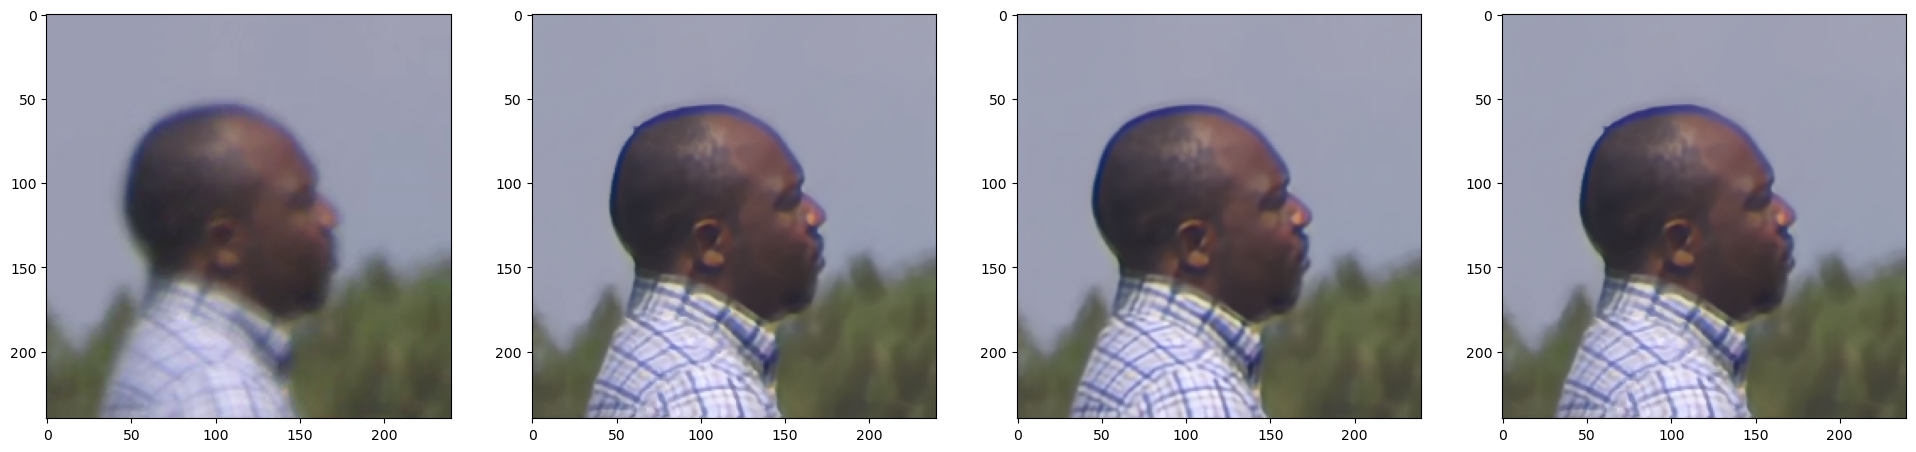

In [112]:
idx = 25
f = plt.figure(figsize=(24,6))
f.add_subplot(1, 4, 1)
plt.imshow(input_all[0,idx,...].permute(1,2,0).detach().cpu().numpy())
f.add_subplot(1, 4, 2)
plt.imshow(tilt[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 3)
plt.imshow(res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 4)
plt.imshow(tilt_img[idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

In [117]:
res.shape

torch.Size([1, 30, 3, 240, 240])

In [30]:
zer_ = sum(collect_zer).cuda()/100
G, redgd, error = cost(res, simulator, input_all, zer_, ksize=45, sigma=1, factor=1)
print(get_psnr(input_all[:, 2:-2, ...], redgd))

37.57202412531926


In [127]:
# lpd_blur = torch.randn((1,30,2,240,240), device='cuda') 
# lpd_blur.requires_grad = True
res, lpd = model(input_all)
mu, logvar = lpd[:,:,2:3,:,:], lpd[:,:,3:4,:,:]
lpd_blur = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
lpd_blur.requires_grad = True
for i in range(100):
    fct = exponential_decay(10, 0.1, 100, i)
    G, redgd, error = cost(res, TS, input_all, lpd_blur, sigma=1, factor=fct)
    G.backward()
    print(i, fct, G.item(), error.item(), get_psnr(input_all, redgd))
    lpd_blur.requires_grad = False
    lpd_blur = lpd_blur - 500 * lpd_blur.grad + torch.randn_like(lpd_blur)*0.01  # 0.001 no effect, 0.05 obvious effect
    lpd_blur.requires_grad = True
    # zer_.grad.zero_()

torch.Size([1, 30, 3, 240, 240]) torch.Size([1, 30, 3, 240, 240])


OutOfMemoryError: CUDA out of memory. Tried to allocate 160.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 121.06 MiB is free. Process 89674 has 1.71 GiB memory in use. Process 105439 has 1.75 GiB memory in use. Including non-PyTorch memory, this process has 75.54 GiB memory in use. Of the allocated memory 74.00 GiB is allocated by PyTorch, and 1.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
print(zer_[:,:,:2,...].max(), zer_[:,:,:2,...].min(), zer_[:,:,2:,...].max(),zer_[:,:,2:,...].min())

tensor(2.9717, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.5920, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4308, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.7216, device='cuda:0', grad_fn=<MinBackward1>)


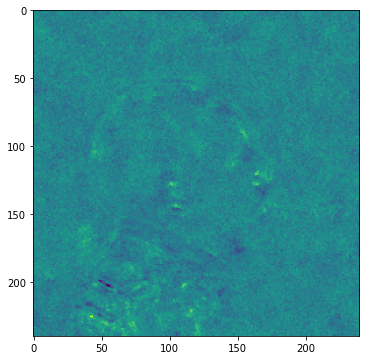

In [24]:
f = plt.figure(figsize=(6,6))
plt.imshow(zer_[0,0,5,...].detach().cpu().numpy())

plt.show(block=True)

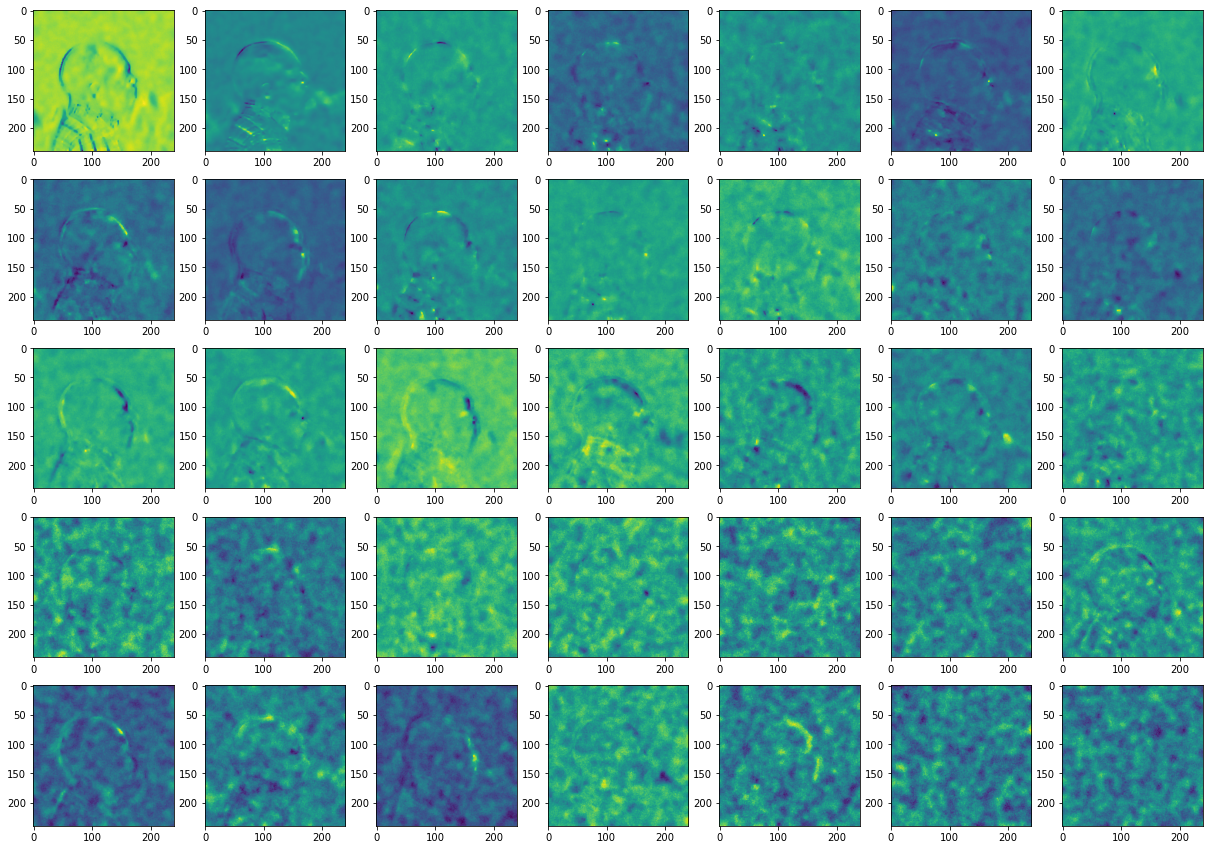

In [27]:
f = plt.figure(figsize=(21,15))
for i in range(5):
    for j in range(7):
        f.add_subplot(5, 7, 7*i+j+1)
        plt.imshow(zer_[0, 25, 7*i+j,...].detach().cpu().numpy())
plt.show(block=True)

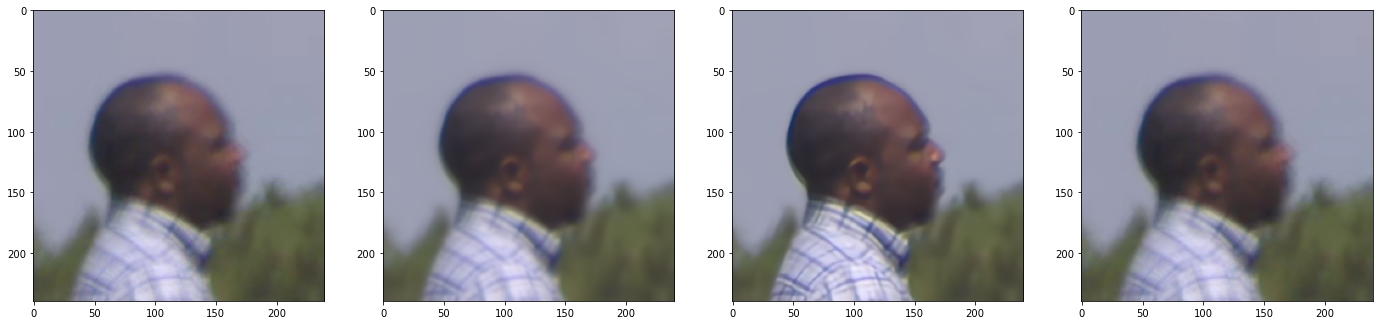

In [28]:
idx = 25
f = plt.figure(figsize=(24,6))
f.add_subplot(1, 4, 1)
plt.imshow(input_all[0,idx+2,...].permute(1,2,0).detach().cpu().numpy())
f.add_subplot(1, 4, 2)
plt.imshow(redgd[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 3)
plt.imshow(res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 4)
plt.imshow(input_all[0,idx+2,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

In [230]:
output_path = "/home/zhan3275/data/tmp"
for idx in range(26):
    inp = input_all[0,idx+2,...].permute(1,2,0).detach().cpu().numpy()
    rd = redgd[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy()
    r = res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy()
    cv2.imwrite(os.path.join(output_path, "input", f"{idx:02d}.png"), cv2.cvtColor((inp*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_path, "redgd", f"{idx:02d}.png"), cv2.cvtColor((rd*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_path, "restore", f"{idx:02d}.png"), cv2.cvtColor((r*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

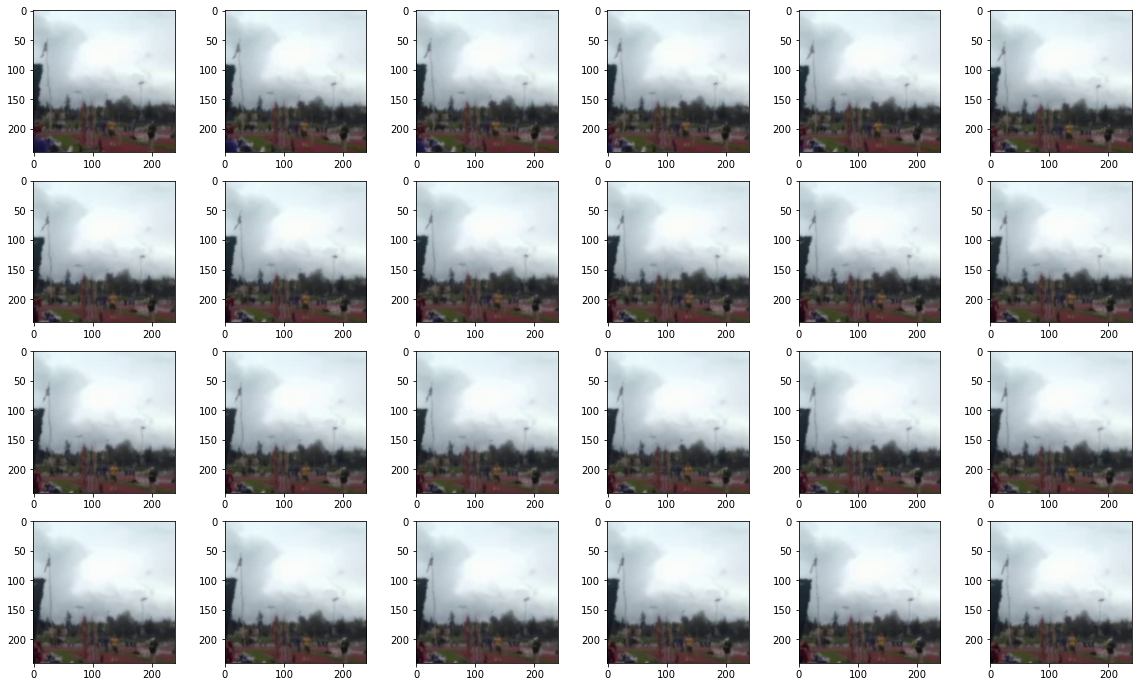

In [136]:
f = plt.figure(figsize=(20,12))
for i in range(4):
    for j in range(6):
        f.add_subplot(4, 6, 6*i+j+1)
        plt.imshow(input_all[0,6*i+j+2,...].permute(1,2,0).detach().cpu().numpy())
plt.show(block=True)

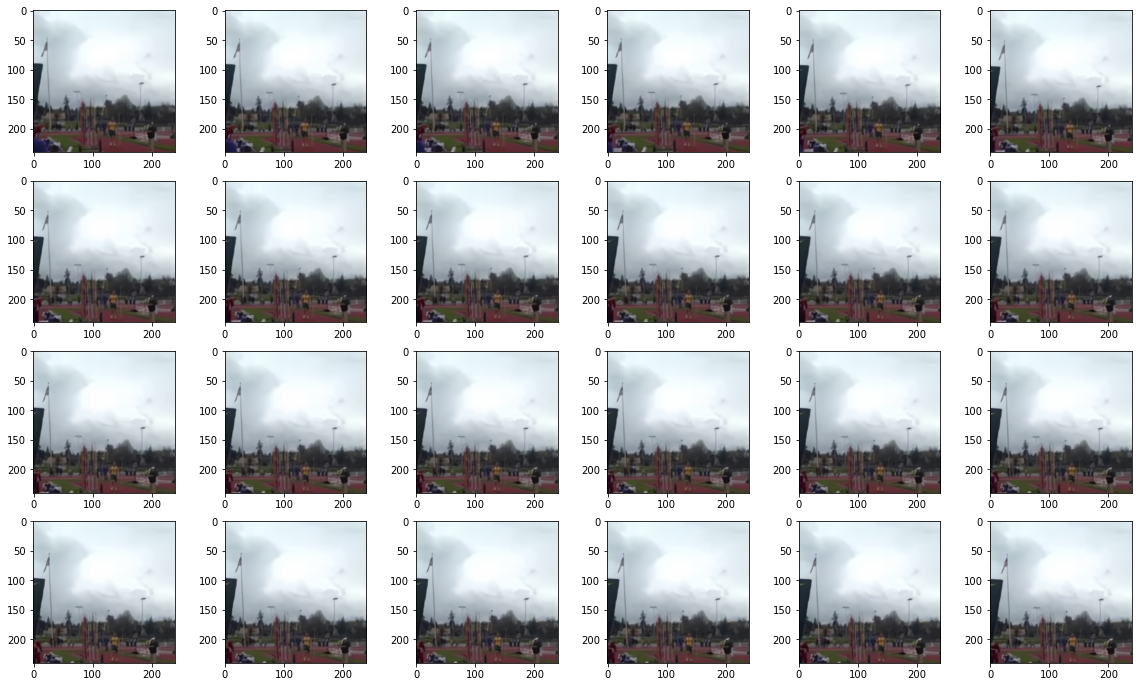

In [141]:
f = plt.figure(figsize=(20,12))
for i in range(4):
    for j in range(6):
        f.add_subplot(4, 6, 6*i+j+1)
        plt.imshow(res[0,6*i+j,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

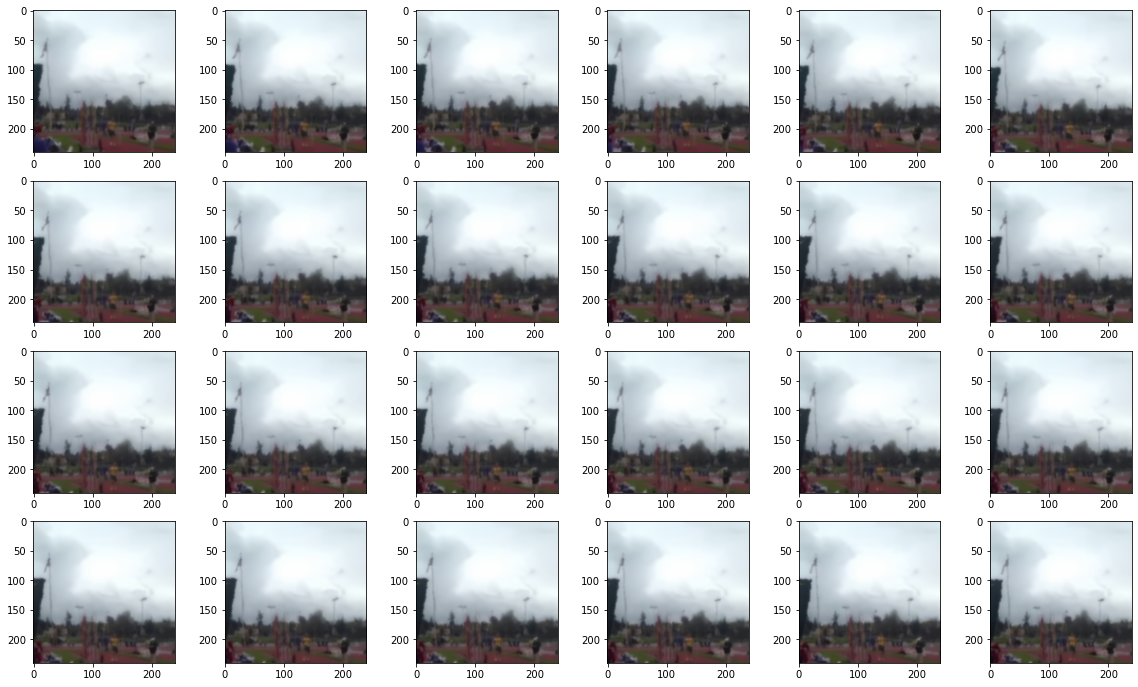

In [142]:
f = plt.figure(figsize=(20,12))
for i in range(4):
    for j in range(6):
        f.add_subplot(4, 6, 6*i+j+1)
        plt.imshow(redgd[0,6*i+j,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

tensor(5.6712, device='cuda:0')

In [29]:
PSNR_lists = []
error_lists = []

count = 0
for data in test_loader:
# for data in train_loader:
    print(count)
    PSNR_list = []
    error_list = []
    input_all = data[0][..., :args.patch_size, :args.patch_size].cuda()
    gt = data[1][..., :args.patch_size, :args.patch_size].cuda()
    # print(data[0][..., :args.patch_size, :args.patch_size].shape)

    zer_ = torch.randn((1,26,35,240,240), device='cuda') 
    zer_.requires_grad = True
    res = model(input_all)
    for i in range(100):
        fct = exponential_decay(10, 0.1, 100, i)
        G, redgd, error = cost(res, simulator, input_all, zer_, ksize=45, sigma=1, factor=fct)
        G.backward()
        error_list.append(error.detach().item())
        PSNR_list.append(get_psnr(input_all[:, 2:-2, ...].detach(), redgd.detach()))
        zer_.requires_grad = False
        zer_ = zer_ - 500 * zer_.grad + torch.randn_like(zer_)*0.01  # 0.001 no effect, 0.05 obvious effect
        zer_.requires_grad = True
    count += 1
    PSNR_lists.append(PSNR_list)
    error_lists.append(error_list)
    if count == 10:
        break

0
1
2
3
4
5
6
7
8
9


In [30]:
PSNRs = []
errors = []
for i in range(100):
    PSNRs.append(sum([l[i] for l in PSNR_lists])/10)
    errors.append(sum([l[i] for l in error_lists])/10)

<Figure size 864x864 with 0 Axes>

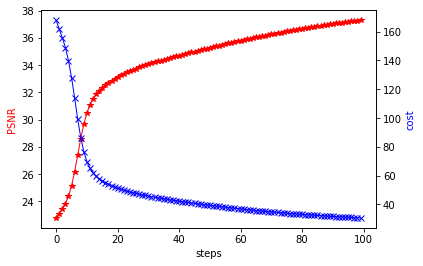

In [15]:
plt.figure(figsize=(12,12))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(PSNRs, marker="*", color="r", linewidth=1)
ax2.plot(errors, marker="x", color="b", linewidth=1)

ax1.set_xlabel('steps')
ax1.set_ylabel('PSNR', color='r')
ax2.set_ylabel('cost', color='b')

plt.show()

Text(0, 0.5, 'PSNR')

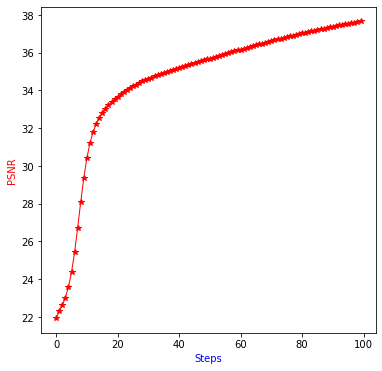

In [31]:
plt.figure(figsize=(6,6))

plt.plot(PSNRs, marker="*", color="r", linewidth=1)
plt.xlabel('Steps', color='b')
plt.ylabel('PSNR', color='r')

In [11]:
# def cost(model, sim, inp, zer_step, ksize=67, sigma=1, factor=1):
#     res = model(inp)
#     redegraded = []
#     redgd = sim(res[0], zer_step[0].permute(0,2,3,1), ksize).unsqueeze(dim=0)
#     # print(torch.norm(inp[:,2:-2,...]-redgd))
#     # redgd = torch.cat(redegraded, dim=1)
#     return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
#             + 1/10000 * factor * torch.norm(zer_step[:,:,:2,...]) \
#             + 1/1000 * factor * torch.norm(zer_step[:,:,2:,...]), res, redgd

def cost2(res, sim, inp, zer_step, ksize=65, sigma=1, factor=1):
    redgd = sim(res[0], zer_step[0].permute(0,2,3,1), ksize).unsqueeze(dim=0)
    # print(torch.norm(inp[:,2:-2,...]-redgd))
    return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
            + 1/10000 * factor * torch.norm(zer_step[:,:,:2,...]) \
            + 1/1000 * factor * torch.norm(zer_step[:,:,2:,...]), res, redgd